# Q2Q Transitive Cluster Analysis

This notebook implements graph-based clustering to find **transitive similarity relationships** between questionnaire items across three surveys (Arivale, Israeli10K, UKBB).

## Problem Statement

When comparing questionnaires pairwise, we miss transitive relationships:
- If A (Arivale) → B (Israeli10K) is best match
- And B (Israeli10K) → C (UKBB) is best match  
- Then {A, B, C} might all be the "same question" across three surveys

## Approach

1. Generate ALL 1,574 "best cross-source match" edges (one per question)
2. Treat as undirected graph and find connected components
3. Connected components = clusters of semantically equivalent questions

## Data Flow

```
1,574 questions (nodes)
    ↓
1,574 "best match" edges (each question → its best cross-source match)
    ↓
Convert to undirected graph
    ↓
Find connected components using Union-Find
    ↓
Clusters of semantically equivalent questions
```

## Cell 1: Setup & Load Data

In [1]:
from __future__ import annotations

import json
from collections import defaultdict
from dataclasses import dataclass, field
from datetime import datetime, UTC
from pathlib import Path
from typing import Any

import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# Paths
DATA_DIR = Path("../../data/questionnaires")
QUESTIONS_PATH = DATA_DIR / "processed" / "questions.json"
OUTPUT_DIR = Path("../../data/review")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Model configuration  
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

# Cross-source matching targets
MATCH_TARGETS: dict[str, list[str]] = {
    "Arivale": ["Israeli10K", "UKBB"],
    "Israeli10K": ["Arivale", "UKBB"],
    "UKBB": ["Arivale", "Israeli10K"],
}

print("Loading questions...")
with open(QUESTIONS_PATH) as f:
    questions = json.load(f)

print(f"Total questions: {len(questions)}")

# Group by source
questions_by_source: dict[str, list[dict]] = defaultdict(list)
question_lookup: dict[str, dict] = {}  # id -> question

for q in questions:
    source = q.get("metadata", {}).get("source_questionnaire", "Unknown")
    questions_by_source[source].append(q)
    question_lookup[q["id"]] = q

print("\nQuestions by source:")
for source, qs in sorted(questions_by_source.items()):
    print(f"  {source}: {len(qs)}")

Loading questions...
Total questions: 1574

Questions by source:
  Arivale: 561
  Israeli10K: 514
  UKBB: 499


In [2]:
# Load embedding model and generate embeddings for all questions
print(f"\nLoading embedding model: {EMBEDDING_MODEL}")
model = SentenceTransformer(EMBEDDING_MODEL)

# Build per-source embeddings and indices
@dataclass
class SourceIndex:
    """FAISS index and metadata for a single source."""
    source: str
    index: faiss.IndexFlatIP
    questions: list[dict[str, Any]]
    id_list: list[str]
    embeddings: np.ndarray

source_indices: dict[str, SourceIndex] = {}

for source, qs in questions_by_source.items():
    print(f"\nBuilding index for {source} ({len(qs)} questions)...")
    
    # Extract texts and IDs
    texts = [q.get("name", "") for q in qs]
    ids = [q.get("id", "") for q in qs]
    
    # Encode
    embeddings = model.encode(
        texts,
        normalize_embeddings=True,
        convert_to_numpy=True,
        show_progress_bar=True,
    )
    
    # Build FAISS index
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings.astype(np.float32))
    
    source_indices[source] = SourceIndex(
        source=source,
        index=index,
        questions=qs,
        id_list=ids,
        embeddings=embeddings,
    )
    
print("\nIndices built successfully!")


Loading embedding model: sentence-transformers/all-MiniLM-L6-v2

Building index for Arivale (561 questions)...


Batches:   0%|          | 0/18 [00:00<?, ?it/s]


Building index for Israeli10K (514 questions)...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]


Building index for UKBB (499 questions)...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Indices built successfully!


In [3]:
# Find ALL best cross-source matches (not just mutual pairs)
# This gives us 1,574 edges - one per question

@dataclass
class BestMatchEdge:
    """An edge from a question to its best cross-source match."""
    source_id: str
    source_text: str
    source_survey: str
    target_id: str
    target_text: str
    target_survey: str
    similarity: float

all_edges: list[BestMatchEdge] = []

for source_name, source_idx in source_indices.items():
    target_sources = MATCH_TARGETS.get(source_name, [])
    if not target_sources:
        continue
    
    print(f"\nMatching {source_name} against {target_sources}...")
    
    # Build combined index of target sources
    target_questions: list[dict[str, Any]] = []
    target_embeddings_list: list[np.ndarray] = []
    target_source_labels: list[str] = []
    
    for target_name in target_sources:
        if target_name not in source_indices:
            continue
        target_idx = source_indices[target_name]
        target_questions.extend(target_idx.questions)
        target_embeddings_list.append(target_idx.embeddings)
        target_source_labels.extend([target_name] * len(target_idx.questions))
    
    if not target_questions:
        continue
    
    # Combine embeddings
    target_embeddings = np.vstack(target_embeddings_list)
    
    # Build combined FAISS index for cross-source search
    d = target_embeddings.shape[1]
    combined_index = faiss.IndexFlatIP(d)
    combined_index.add(target_embeddings.astype(np.float32))
    
    # Search for best match for each source question
    scores, indices = combined_index.search(source_idx.embeddings.astype(np.float32), 1)
    
    # Build edges
    for i, source_q in enumerate(source_idx.questions):
        idx = indices[i, 0]
        if idx < 0:
            continue
        
        target_q = target_questions[idx]
        target_source = target_source_labels[idx]
        sim = float(scores[i, 0])
        
        all_edges.append(BestMatchEdge(
            source_id=source_q["id"],
            source_text=source_q["name"],
            source_survey=source_name,
            target_id=target_q["id"],
            target_text=target_q["name"],
            target_survey=target_source,
            similarity=sim,
        ))
    
    print(f"  Generated {len(source_idx.questions)} edges from {source_name}")

print(f"\n=== Total edges: {len(all_edges)} ===")
print(f"(Expected: {len(questions)} - one edge per question)")


Matching Arivale against ['Israeli10K', 'UKBB']...
  Generated 561 edges from Arivale

Matching Israeli10K against ['Arivale', 'UKBB']...
  Generated 514 edges from Israeli10K

Matching UKBB against ['Arivale', 'Israeli10K']...
  Generated 499 edges from UKBB

=== Total edges: 1574 ===
(Expected: 1574 - one edge per question)


## Cell 2: Edge Similarity Distribution

In [4]:
# Analyze distribution of similarity scores
similarities = np.array([e.similarity for e in all_edges])

print("Similarity Score Statistics")
print("=" * 40)
print(f"  Count:  {len(similarities)}")
print(f"  Min:    {similarities.min():.4f}")
print(f"  Max:    {similarities.max():.4f}")
print(f"  Mean:   {similarities.mean():.4f}")
print(f"  Median: {np.median(similarities):.4f}")
print(f"  Std:    {similarities.std():.4f}")

# Percentiles
print("\nPercentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p}th: {np.percentile(similarities, p):.4f}")

# Threshold analysis
print("\nEdges above threshold:")
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    count = (similarities >= thresh).sum()
    pct = count / len(similarities) * 100
    print(f"  ≥ {thresh}: {count:4d} ({pct:5.1f}%)")

Similarity Score Statistics
  Count:  1574
  Min:    0.2071
  Max:    1.0000
  Mean:   0.5222
  Median: 0.5231
  Std:    0.1428

Percentiles:
  10th: 0.3252
  25th: 0.4142
  50th: 0.5231
  75th: 0.6233
  90th: 0.7082
  95th: 0.7651
  99th: 0.8427

Edges above threshold:
  ≥ 0.3: 1487 ( 94.5%)
  ≥ 0.4: 1218 ( 77.4%)
  ≥ 0.5:  873 ( 55.5%)
  ≥ 0.6:  487 ( 30.9%)
  ≥ 0.7:  176 ( 11.2%)
  ≥ 0.8:   32 (  2.0%)
  ≥ 0.9:    5 (  0.3%)


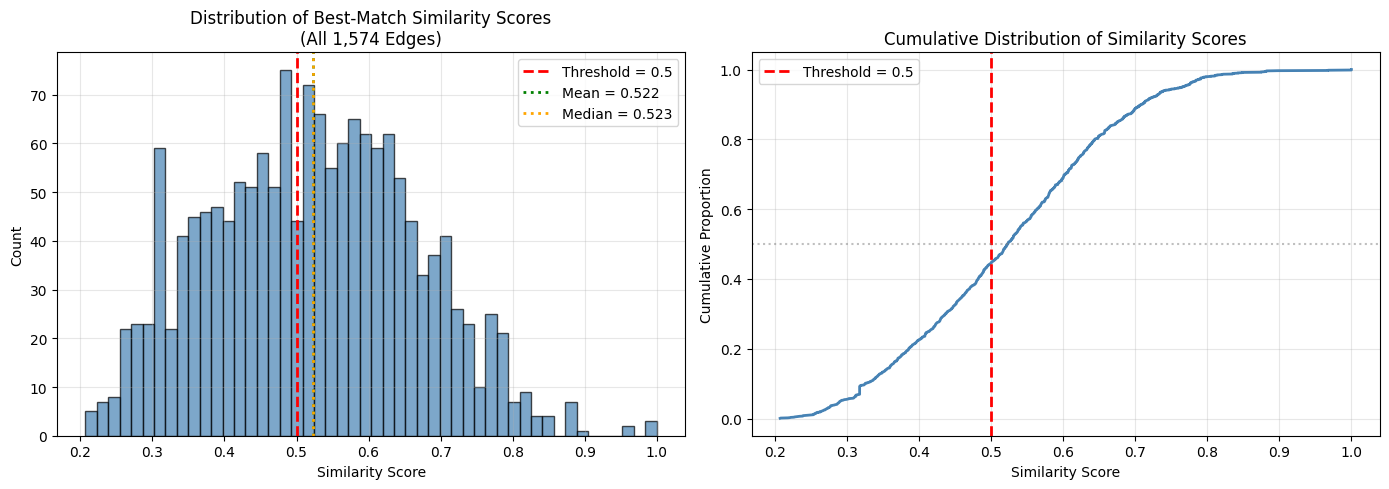


Edges by source→target direction:
  Arivale→Israeli10K: 469 edges, mean sim = 0.5026
  Arivale→UKBB: 92 edges, mean sim = 0.4831
  Israeli10K→Arivale: 293 edges, mean sim = 0.5894
  Israeli10K→UKBB: 221 edges, mean sim = 0.5833
  UKBB→Arivale: 175 edges, mean sim = 0.4388
  UKBB→Israeli10K: 324 edges, mean sim = 0.5043


In [5]:
# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(similarities, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
ax1.axvline(x=similarities.mean(), color='green', linestyle=':', linewidth=2, label=f'Mean = {similarities.mean():.3f}')
ax1.axvline(x=np.median(similarities), color='orange', linestyle=':', linewidth=2, label=f'Median = {np.median(similarities):.3f}')
ax1.set_xlabel('Similarity Score')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Best-Match Similarity Scores\n(All 1,574 Edges)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative distribution
ax2 = axes[1]
sorted_sims = np.sort(similarities)
cumulative = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
ax2.plot(sorted_sims, cumulative, color='steelblue', linewidth=2)
ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
ax2.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Similarity Score')
ax2.set_ylabel('Cumulative Proportion')
ax2.set_title('Cumulative Distribution of Similarity Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show edges by source-pair direction
print("\nEdges by source→target direction:")
direction_counts = defaultdict(list)
for e in all_edges:
    key = f"{e.source_survey}→{e.target_survey}"
    direction_counts[key].append(e.similarity)

for direction, sims in sorted(direction_counts.items()):
    print(f"  {direction}: {len(sims)} edges, mean sim = {np.mean(sims):.4f}")

## Cell 3: Union-Find Implementation

In [6]:
class UnionFind:
    """Disjoint set data structure for efficient clustering.
    
    Uses path compression and union by rank for O(α(n)) amortized operations,
    where α is the inverse Ackermann function (effectively constant).
    """
    
    def __init__(self):
        self.parent: dict[str, str] = {}
        self.rank: dict[str, int] = {}
    
    def find(self, x: str) -> str:
        """Find root of set containing x with path compression."""
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0
            return x
        
        # Path compression: make all nodes point directly to root
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    
    def union(self, x: str, y: str) -> None:
        """Merge sets containing x and y using union by rank."""
        root_x = self.find(x)
        root_y = self.find(y)
        
        if root_x == root_y:
            return
        
        # Union by rank: attach smaller tree under larger
        if self.rank[root_x] < self.rank[root_y]:
            self.parent[root_x] = root_y
        elif self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
        else:
            self.parent[root_y] = root_x
            self.rank[root_x] += 1
    
    def get_clusters(self) -> dict[str, list[str]]:
        """Return all clusters as {root_id: [member_ids]}."""
        clusters: dict[str, list[str]] = defaultdict(list)
        for x in self.parent:
            root = self.find(x)
            clusters[root].append(x)
        return dict(clusters)


def run_clustering(edges: list[BestMatchEdge], min_similarity: float | None = None) -> dict[str, list[str]]:
    """Run Union-Find clustering on edges.
    
    Args:
        edges: List of best-match edges
        min_similarity: If provided, only include edges with similarity >= this threshold
    
    Returns:
        Dict mapping cluster root ID to list of member question IDs
    """
    uf = UnionFind()
    
    # First, add all questions as singleton nodes
    for q in questions:
        uf.find(q["id"])
    
    # Then process edges
    edges_used = 0
    for edge in edges:
        if min_similarity is not None and edge.similarity < min_similarity:
            continue
        uf.union(edge.source_id, edge.target_id)
        edges_used += 1
    
    print(f"Processed {edges_used} edges (threshold: {min_similarity})")
    return uf.get_clusters()

print("Union-Find implementation ready.")

Union-Find implementation ready.


## Cell 4: Clustering with No Threshold

In [7]:
# Run clustering with NO threshold (all edges)
print("Running clustering with NO threshold (all edges)...")
clusters_all = run_clustering(all_edges, min_similarity=None)

# Analyze results
def analyze_clusters(clusters: dict[str, list[str]], label: str) -> dict:
    """Analyze clustering results."""
    print(f"\n{'=' * 60}")
    print(f"Cluster Analysis: {label}")
    print(f"{'=' * 60}")
    
    # Basic stats
    sizes = [len(members) for members in clusters.values()]
    total_questions = sum(sizes)
    
    print(f"\nTotal clusters: {len(clusters)}")
    print(f"Total questions: {total_questions}")
    print(f"\nCluster size statistics:")
    print(f"  Min size:    {min(sizes)}")
    print(f"  Max size:    {max(sizes)}")
    print(f"  Mean size:   {np.mean(sizes):.2f}")
    print(f"  Median size: {np.median(sizes):.1f}")
    
    # Size distribution
    size_counts = defaultdict(int)
    for size in sizes:
        if size <= 4:
            size_counts[str(size)] += 1
        elif size <= 10:
            size_counts["5-10"] += 1
        else:
            size_counts[">10"] += 1
    
    print(f"\nSize distribution:")
    for key in ["1", "2", "3", "4", "5-10", ">10"]:
        count = size_counts.get(key, 0)
        print(f"  Size {key}: {count} clusters")
    
    # Source coverage analysis
    source_coverage = defaultdict(int)
    three_way = 0
    two_way = 0
    single_source = 0
    
    for members in clusters.values():
        sources = set()
        for qid in members:
            if qid in question_lookup:
                src = question_lookup[qid].get("metadata", {}).get("source_questionnaire", "Unknown")
                sources.add(src)
        
        sources_key = ",".join(sorted(sources))
        source_coverage[sources_key] += 1
        
        if len(sources) == 3:
            three_way += 1
        elif len(sources) == 2:
            two_way += 1
        else:
            single_source += 1
    
    print(f"\nSource coverage:")
    print(f"  3-way (all three sources): {three_way}")
    print(f"  2-way (two sources):       {two_way}")
    print(f"  Single source:             {single_source}")
    
    print(f"\nDetailed source combinations:")
    for combo, count in sorted(source_coverage.items()):
        print(f"  {combo}: {count}")
    
    return {
        "total_clusters": len(clusters),
        "total_questions": total_questions,
        "size_distribution": dict(size_counts),
        "three_way": three_way,
        "two_way": two_way,
        "single_source": single_source,
        "source_coverage": dict(source_coverage),
    }

stats_all = analyze_clusters(clusters_all, "No Threshold")

Running clustering with NO threshold (all edges)...
Processed 1574 edges (threshold: None)

Cluster Analysis: No Threshold

Total clusters: 226
Total questions: 1574

Cluster size statistics:
  Min size:    2
  Max size:    50
  Mean size:   6.96
  Median size: 5.0

Size distribution:
  Size 1: 0 clusters
  Size 2: 44 clusters
  Size 3: 37 clusters
  Size 4: 26 clusters
  Size 5-10: 83 clusters
  Size >10: 36 clusters

Source coverage:
  3-way (all three sources): 103
  2-way (two sources):       123
  Single source:             0

Detailed source combinations:
  Arivale,Israeli10K: 42
  Arivale,Israeli10K,UKBB: 103
  Arivale,UKBB: 18
  Israeli10K,UKBB: 63


## Cell 5: Clustering with 0.5 Threshold

In [8]:
# Run clustering with threshold = 0.5
print("Running clustering with threshold = 0.5...")
clusters_filtered = run_clustering(all_edges, min_similarity=0.5)

stats_filtered = analyze_clusters(clusters_filtered, "Threshold ≥ 0.5")

Running clustering with threshold = 0.5...
Processed 873 edges (threshold: 0.5)

Cluster Analysis: Threshold ≥ 0.5

Total clusters: 909
Total questions: 1574

Cluster size statistics:
  Min size:    1
  Max size:    27
  Mean size:   1.73
  Median size: 1.0

Size distribution:
  Size 1: 701 clusters
  Size 2: 73 clusters
  Size 3: 44 clusters
  Size 4: 29 clusters
  Size 5-10: 54 clusters
  Size >10: 8 clusters

Source coverage:
  3-way (all three sources): 59
  2-way (two sources):       149
  Single source:             701

Detailed source combinations:
  Arivale: 309
  Arivale,Israeli10K: 56
  Arivale,Israeli10K,UKBB: 59
  Arivale,UKBB: 13
  Israeli10K: 122
  Israeli10K,UKBB: 80
  UKBB: 270


## Cell 6: Side-by-Side Comparison

In [9]:
# Compare the two approaches
comparison_data = [
    ["Metric", "No Threshold", "Threshold ≥ 0.5"],
    ["Total clusters", stats_all["total_clusters"], stats_filtered["total_clusters"]],
    ["3-way clusters (ideal)", stats_all["three_way"], stats_filtered["three_way"]],
    ["2-way clusters", stats_all["two_way"], stats_filtered["two_way"]],
    ["Single-source clusters", stats_all["single_source"], stats_filtered["single_source"]],
    ["Size=1 (singletons)", stats_all["size_distribution"].get("1", 0), stats_filtered["size_distribution"].get("1", 0)],
    ["Size=2 (pairs)", stats_all["size_distribution"].get("2", 0), stats_filtered["size_distribution"].get("2", 0)],
    ["Size=3 (triplets)", stats_all["size_distribution"].get("3", 0), stats_filtered["size_distribution"].get("3", 0)],
    ["Size>10 (suspicious)", stats_all["size_distribution"].get(">10", 0), stats_filtered["size_distribution"].get(">10", 0)],
]

comparison_df = pd.DataFrame(comparison_data[1:], columns=comparison_data[0])
print("\n" + "=" * 70)
print("COMPARISON: No Threshold vs Threshold ≥ 0.5")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("\n")

# Interpretation
print("Key observations:")
singleton_diff = stats_filtered["size_distribution"].get("1", 0) - stats_all["size_distribution"].get("1", 0)
if singleton_diff > 0:
    print(f"  - Threshold creates {singleton_diff} additional singleton clusters (questions with no good match)")

three_way_diff = stats_all["three_way"] - stats_filtered["three_way"]
if three_way_diff != 0:
    print(f"  - 3-way clusters: {stats_all['three_way']} (no threshold) vs {stats_filtered['three_way']} (threshold)")

suspicious_all = stats_all["size_distribution"].get(">10", 0)
suspicious_filtered = stats_filtered["size_distribution"].get(">10", 0)
if suspicious_all > 0 or suspicious_filtered > 0:
    print(f"  - Large clusters (>10): {suspicious_all} (no threshold) vs {suspicious_filtered} (threshold)")


COMPARISON: No Threshold vs Threshold ≥ 0.5
                Metric  No Threshold  Threshold ≥ 0.5
        Total clusters           226              909
3-way clusters (ideal)           103               59
        2-way clusters           123              149
Single-source clusters             0              701
   Size=1 (singletons)             0              701
        Size=2 (pairs)            44               73
     Size=3 (triplets)            37               44
  Size>10 (suspicious)            36                8


Key observations:
  - Threshold creates 701 additional singleton clusters (questions with no good match)
  - 3-way clusters: 103 (no threshold) vs 59 (threshold)
  - Large clusters (>10): 36 (no threshold) vs 8 (threshold)


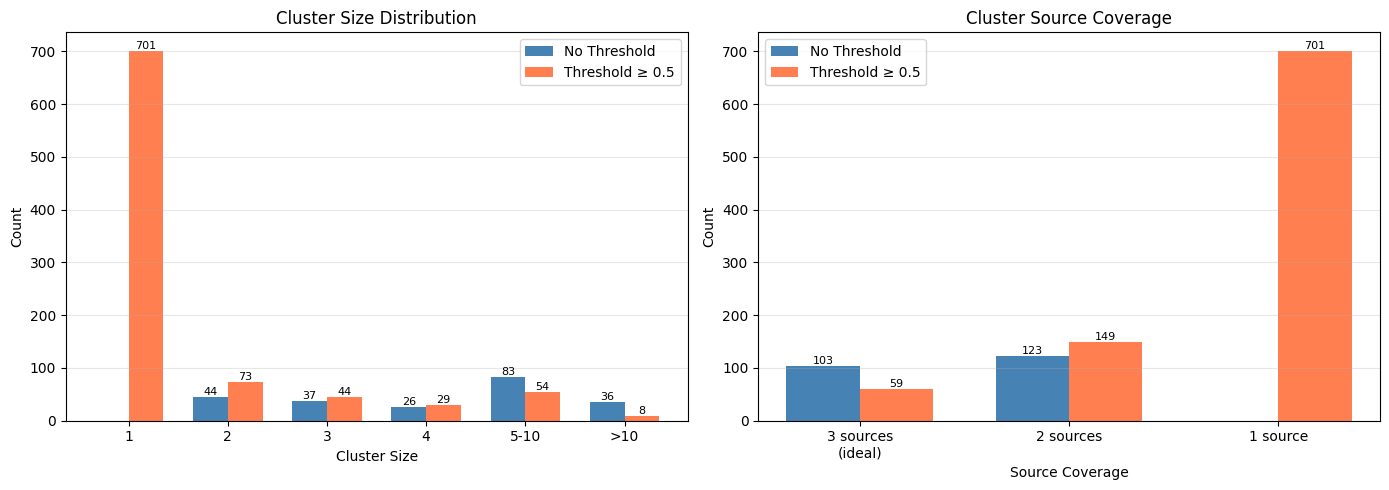

In [10]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster size distribution comparison
ax1 = axes[0]
categories = ["1", "2", "3", "4", "5-10", ">10"]
values_all = [stats_all["size_distribution"].get(c, 0) for c in categories]
values_filtered = [stats_filtered["size_distribution"].get(c, 0) for c in categories]

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, values_all, width, label='No Threshold', color='steelblue')
bars2 = ax1.bar(x + width/2, values_filtered, width, label='Threshold ≥ 0.5', color='coral')

ax1.set_xlabel('Cluster Size')
ax1.set_ylabel('Count')
ax1.set_title('Cluster Size Distribution')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    if bar.get_height() > 0:
        ax1.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=8)
for bar in bars2:
    if bar.get_height() > 0:
        ax1.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=8)

# Source coverage comparison
ax2 = axes[1]
coverage_cats = ["3 sources\n(ideal)", "2 sources", "1 source"]
coverage_all = [stats_all["three_way"], stats_all["two_way"], stats_all["single_source"]]
coverage_filtered = [stats_filtered["three_way"], stats_filtered["two_way"], stats_filtered["single_source"]]

x = np.arange(len(coverage_cats))
bars1 = ax2.bar(x - width/2, coverage_all, width, label='No Threshold', color='steelblue')
bars2 = ax2.bar(x + width/2, coverage_filtered, width, label='Threshold ≥ 0.5', color='coral')

ax2.set_xlabel('Source Coverage')
ax2.set_ylabel('Count')
ax2.set_title('Cluster Source Coverage')
ax2.set_xticks(x)
ax2.set_xticklabels(coverage_cats)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    if bar.get_height() > 0:
        ax2.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=8)
for bar in bars2:
    if bar.get_height() > 0:
        ax2.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## Cell 7: Inspect 3-Way Clusters (Ideal Matches)

In [11]:
def build_cluster_details(clusters: dict[str, list[str]], edges: list[BestMatchEdge]) -> list[dict]:
    """Build detailed cluster information including edges and statistics."""
    # Build edge lookup for similarity scores
    edge_lookup: dict[tuple[str, str], float] = {}
    for e in edges:
        edge_lookup[(e.source_id, e.target_id)] = e.similarity
        # Also store reverse for undirected lookup
        edge_lookup[(e.target_id, e.source_id)] = e.similarity
    
    cluster_details = []
    cluster_id = 0
    
    for root, members in clusters.items():
        cluster_id += 1
        
        # Get question details and sources
        questions_in_cluster = []
        sources = set()
        
        for qid in members:
            if qid in question_lookup:
                q = question_lookup[qid]
                src = q.get("metadata", {}).get("source_questionnaire", "Unknown")
                sources.add(src)
                questions_in_cluster.append({
                    "id": qid,
                    "text": q.get("name", ""),
                    "source": src,
                })
        
        # Find edges within cluster
        cluster_edges = []
        member_set = set(members)
        for e in edges:
            if e.source_id in member_set and e.target_id in member_set:
                cluster_edges.append({
                    "from": e.source_id,
                    "to": e.target_id,
                    "similarity": e.similarity,
                })
        
        # Calculate average similarity
        avg_sim = np.mean([e["similarity"] for e in cluster_edges]) if cluster_edges else 0.0
        
        cluster_details.append({
            "cluster_id": cluster_id,
            "size": len(members),
            "sources": sorted(sources),
            "num_sources": len(sources),
            "questions": questions_in_cluster,
            "edges": cluster_edges,
            "avg_similarity": round(avg_sim, 4),
        })
    
    # Sort by num_sources (desc), then by avg_similarity (desc)
    cluster_details.sort(key=lambda x: (-x["num_sources"], -x["avg_similarity"]))
    
    # Re-number after sorting
    for i, c in enumerate(cluster_details):
        c["cluster_id"] = i + 1
    
    return cluster_details


# Build details for both versions
print("Building cluster details...")
details_all = build_cluster_details(clusters_all, all_edges)
details_filtered = build_cluster_details(clusters_filtered, all_edges)
print(f"Built details for {len(details_all)} (no threshold) and {len(details_filtered)} (filtered) clusters.")

Building cluster details...
Built details for 226 (no threshold) and 909 (filtered) clusters.


In [12]:
# Display 3-way clusters (ideal matches)
def display_three_way_clusters(details: list[dict], label: str, max_display: int = 20):
    """Display clusters that contain all three sources."""
    three_way = [c for c in details if c["num_sources"] == 3]
    
    print(f"\n{'=' * 70}")
    print(f"3-WAY CLUSTERS ({label}) - {len(three_way)} total")
    print(f"{'=' * 70}")
    
    if not three_way:
        print("No 3-way clusters found.")
        return
    
    for i, cluster in enumerate(three_way[:max_display]):
        print(f"\n--- Cluster {cluster['cluster_id']} (size={cluster['size']}, avg_sim={cluster['avg_similarity']:.3f}) ---")
        
        # Group questions by source for display
        by_source = defaultdict(list)
        for q in cluster["questions"]:
            by_source[q["source"]].append(q)
        
        for source in ["Arivale", "Israeli10K", "UKBB"]:
            if source in by_source:
                for q in by_source[source]:
                    text_preview = q["text"][:70] + "..." if len(q["text"]) > 70 else q["text"]
                    print(f"  [{source:10s}] {text_preview}")
    
    if len(three_way) > max_display:
        print(f"\n... and {len(three_way) - max_display} more 3-way clusters")

# Show from both versions
display_three_way_clusters(details_all, "No Threshold")
display_three_way_clusters(details_filtered, "Threshold ≥ 0.5")


3-WAY CLUSTERS (No Threshold) - 103 total

--- Cluster 1 (size=6, avg_sim=0.776) ---
  [Arivale   ] Glaucoma
  [Arivale   ] Glaucoma
  [Israeli10K] Which eye(s) affected by glaucoma
  [Israeli10K] Age glaucoma diagnosed
  [UKBB      ] ACE touchscreen question What was your age when glaucoma was first dia...
  [UKBB      ] ACE touchscreen question Which eye(s) are affected by glaucoma?

--- Cluster 2 (size=6, avg_sim=0.749) ---
  [Arivale   ] Mild cognitive impairment (MCI)
  [Arivale   ] Macular degeneration
  [Israeli10K] Which eye(s) affected by macular degeneration
  [Israeli10K] Age macular degeneration diagnosed
  [UKBB      ] ACE touchscreen question Which eye(s) are affected by macular degenera...
  [UKBB      ] ACE touchscreen question What was your age when macular degeneration w...

--- Cluster 3 (size=4, avg_sim=0.732) ---
  [Arivale   ] Type 1 diabetes
  [Arivale   ] Diabetes - Type 1
  [Israeli10K] Type 1 diabetes family number
  [UKBB      ] ACE touchscreen question Did 

## Cell 8: Inspect Large Clusters (>5 Questions) - Suspicious

In [13]:
# Display large clusters that may need manual review
def display_large_clusters(details: list[dict], label: str, min_size: int = 5):
    """Display large clusters that may be overly broad."""
    large = [c for c in details if c["size"] > min_size]
    large.sort(key=lambda x: -x["size"])
    
    print(f"\n{'=' * 70}")
    print(f"LARGE CLUSTERS (>{min_size} questions) - {label} - {len(large)} total")
    print(f"{'=' * 70}")
    
    if not large:
        print(f"No clusters with >{min_size} questions found.")
        return
    
    for cluster in large:
        sources_str = ",".join(cluster["sources"])
        print(f"\n--- Cluster {cluster['cluster_id']} (size={cluster['size']}, sources={sources_str}, avg_sim={cluster['avg_similarity']:.3f}) ---")
        
        for q in cluster["questions"]:
            text_preview = q["text"][:60] + "..." if len(q["text"]) > 60 else q["text"]
            print(f"  [{q['source']:10s}] {text_preview}")
        
        print(f"  [WARNING] Large cluster - may represent overly broad concept")

display_large_clusters(details_all, "No Threshold")
display_large_clusters(details_filtered, "Threshold ≥ 0.5")


LARGE CLUSTERS (>5 questions) - No Threshold - 105 total

--- Cluster 102 (size=50, sources=Arivale,Israeli10K,UKBB, avg_sim=0.372) ---
  [Arivale   ] Other screening exam
  [Israeli10K] Collection timestamp
  [Israeli10K] Collection date
  [Israeli10K] Performed tests
  [Israeli10K] Other test performed past year description
  [UKBB      ] This is the number of puzzles which the participant viewed i...
  [UKBB      ] The tests were described by an outer array of 32 symbol-digi...
  [UKBB      ] This is an array of values indicating the digit that the par...
  [UKBB      ] This is the number of symbols correctly matched to digits by...
  [UKBB      ] This is the number of puzzles which the participant viewed i...
  [UKBB      ] Number of puzzles correct, scored from the participant answe...
  [UKBB      ] Which of the four pictures was chosen by the participant, fo...
  [UKBB      ] This is the Standard Error (corresponding to the MLE calcula...
  [UKBB      ] This is the letter displ

## Cell 9: Export Results

In [14]:
def export_clusters(details: list[dict], stats: dict, suffix: str):
    """Export cluster results to JSON and TSV."""
    
    # JSON output
    json_output = {
        "clusters": details,
        "statistics": stats,
        "metadata": {
            "generated_at": datetime.now(UTC).isoformat(),
            "total_questions": len(questions),
            "total_edges": len(all_edges),
            "embedding_model": EMBEDDING_MODEL,
            "threshold": None if suffix == "all" else 0.5,
        }
    }
    
    json_path = OUTPUT_DIR / f"q2q_clusters_{suffix}.json"
    with open(json_path, "w") as f:
        json.dump(json_output, f, indent=2)
    print(f"Saved: {json_path}")
    
    # TSV output (flat format for spreadsheet review)
    rows = []
    for cluster in details:
        sources_str = ",".join(s[0] for s in cluster["sources"])  # A,I,U abbreviation
        for q in cluster["questions"]:
            rows.append({
                "cluster_id": cluster["cluster_id"],
                "cluster_size": cluster["size"],
                "sources": sources_str,
                "num_sources": cluster["num_sources"],
                "question_id": q["id"],
                "question_text": q["text"],
                "source_survey": q["source"],
                "avg_cluster_similarity": cluster["avg_similarity"],
            })
    
    df = pd.DataFrame(rows)
    tsv_path = OUTPUT_DIR / f"q2q_clusters_{suffix}.tsv"
    df.to_csv(tsv_path, sep="\t", index=False)
    print(f"Saved: {tsv_path} ({len(rows)} rows)")
    
    return json_path, tsv_path

# Export both versions
print("\n" + "=" * 70)
print("EXPORTING RESULTS")
print("=" * 70)

json_all, tsv_all = export_clusters(details_all, stats_all, "all")
json_filtered, tsv_filtered = export_clusters(details_filtered, stats_filtered, "filtered")


EXPORTING RESULTS
Saved: ../../data/review/q2q_clusters_all.json
Saved: ../../data/review/q2q_clusters_all.tsv (1574 rows)
Saved: ../../data/review/q2q_clusters_filtered.json
Saved: ../../data/review/q2q_clusters_filtered.tsv (1574 rows)


In [15]:
# Generate summary markdown
summary_md = f"""# Q2Q Transitive Cluster Analysis Summary

Generated: {datetime.now(UTC).isoformat()}

## Overview

This analysis uses Union-Find clustering on best-match edges to discover transitive
similarity relationships across three questionnaire surveys:
- **Arivale**: {len(questions_by_source.get('Arivale', []))} questions
- **Israeli10K**: {len(questions_by_source.get('Israeli10K', []))} questions  
- **UKBB**: {len(questions_by_source.get('UKBB', []))} questions

**Total questions**: {len(questions)}
**Total edges**: {len(all_edges)} (one per question to its best cross-source match)

## Comparison: No Threshold vs Threshold ≥ 0.5

| Metric | No Threshold | Threshold ≥ 0.5 |
|--------|--------------|------------------|
| Total clusters | {stats_all['total_clusters']} | {stats_filtered['total_clusters']} |
| 3-way clusters (ideal) | {stats_all['three_way']} | {stats_filtered['three_way']} |
| 2-way clusters | {stats_all['two_way']} | {stats_filtered['two_way']} |
| Single-source clusters | {stats_all['single_source']} | {stats_filtered['single_source']} |
| Singletons (size=1) | {stats_all['size_distribution'].get('1', 0)} | {stats_filtered['size_distribution'].get('1', 0)} |
| Large clusters (>10) | {stats_all['size_distribution'].get('>10', 0)} | {stats_filtered['size_distribution'].get('>10', 0)} |

## Edge Similarity Statistics

- **Min**: {similarities.min():.4f}
- **Max**: {similarities.max():.4f}
- **Mean**: {similarities.mean():.4f}
- **Median**: {np.median(similarities):.4f}
- **Std**: {similarities.std():.4f}

## Output Files

- `q2q_clusters_all.json` - All clusters (no threshold)
- `q2q_clusters_all.tsv` - Flat format (no threshold)  
- `q2q_clusters_filtered.json` - Clusters with edges ≥ 0.5 similarity
- `q2q_clusters_filtered.tsv` - Flat format (filtered)

## Cluster Quality Criteria

- **Ideal**: 3 questions, one from each source, all high similarity
- **Good**: 2 questions from 2 sources with high similarity
- **Acceptable**: 2+ questions, any source mix
- **Suspicious**: >5 questions (may represent overly broad concept - needs manual review)

## Methodology

1. Embed all questions using `{EMBEDDING_MODEL}`
2. For each question, find its best semantic match from OTHER sources
3. Create an undirected edge graph (1,574 edges total)
4. Find connected components using Union-Find algorithm
5. Connected components = clusters of semantically equivalent questions
"""

summary_path = OUTPUT_DIR / "q2q_cluster_summary.md"
with open(summary_path, "w") as f:
    f.write(summary_md)
print(f"\nSaved summary: {summary_path}")


Saved summary: ../../data/review/q2q_cluster_summary.md


In [16]:
# Final summary
print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)
print(f"\nTotal questions analyzed: {len(questions)}")
print(f"Total edges processed: {len(all_edges)}")
print(f"\nClusters found:")
print(f"  No threshold: {stats_all['total_clusters']} clusters")
print(f"    - 3-way (ideal): {stats_all['three_way']}")
print(f"    - 2-way: {stats_all['two_way']}")
print(f"    - Single-source: {stats_all['single_source']}")
print(f"\n  Threshold ≥ 0.5: {stats_filtered['total_clusters']} clusters")
print(f"    - 3-way (ideal): {stats_filtered['three_way']}")
print(f"    - 2-way: {stats_filtered['two_way']}")
print(f"    - Single-source: {stats_filtered['single_source']}")
print(f"\nOutput files saved to: {OUTPUT_DIR}")


ANALYSIS COMPLETE

Total questions analyzed: 1574
Total edges processed: 1574

Clusters found:
  No threshold: 226 clusters
    - 3-way (ideal): 103
    - 2-way: 123
    - Single-source: 0

  Threshold ≥ 0.5: 909 clusters
    - 3-way (ideal): 59
    - 2-way: 149
    - Single-source: 701

Output files saved to: ../../data/review
